In [183]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg, seaborn as sns, nltk, re
import time, warnings
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import logging
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
import tensorflow_hub as hub
import tensorflow_text 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

from os import listdir

from keras.applications.vgg16 import VGG16 
from keras.applications import ResNet50
from keras.layers import Dense
from keras import Model
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet

from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical

from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D

from matplotlib.image import imread
import time, cv2
from sklearn import cluster, metrics

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

# logging.disable(logging.WARNING)

In [53]:
# Fonctions communes pour la classification de texte et d'image

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words

stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, n_comp = 2, perplexity = 30) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=n_comp,
                         perplexity=perplexity,
                         n_iter=2000, 
                         init='random',
                         learning_rate=200,
                         random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, y_cat = l_cat) :
    fig = plt.figure(figsize=(15,6))
    if X_tsne.shape[1]==2:
        ax = fig.add_subplot(121)
        scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
        plt.title('TSNE selon les vraies classes')
        ax.legend(handles=scatter.legend_elements()[0], labels=set(y_cat), loc="best", title="Clusters")
        ax = fig.add_subplot(122)
        scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
        ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
        plt.title('TSNE selon les clusters')
    else:
        ax = fig.add_subplot(121, projection='3d')
        scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], c=y_cat_num, cmap='Set1')
        plt.title('TSNE selon les vraies classes')
        ax = fig.add_subplot(122, projection='3d')
        scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2],c=labels, cmap='Set1')
        ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
        plt.title('TSNE selon les clusters')    
    plt.show()
    print("ARI : ", ARI)

# Analyse

In [54]:
data_0 = pd.read_csv("Flipkart/flipkart_com-ecommerce_sample_1050.csv", sep = ',', encoding = 'utf-8')
# data_0["description"] = data_0["product_name"] + " " + data_0["description"]
data_0.shape

(1050, 15)

## Création de la variable category

In [4]:
data_0.loc[780,"product_category_tree"]

'["Watches >> Wrist Watches >> Perucci Wrist Watches"]'

In [29]:
print("number_of_categories with second tree level :",
      data_0["product_category_tree"].apply(lambda x : get_cat(x,1)).value_counts().shape[0])
print("number_of_categories with first tree level :",
      data_0["product_category_tree"].apply(lambda x : get_cat(x,0)).value_counts().shape[0],
     "\n")
print("distribution of first level category :")
print(data_0["product_category_tree"].apply(lambda x : get_cat(x,0)).value_counts())

number_of_categories with second tree level : 62
number_of_categories with first tree level : 7 

distribution of first level category :
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: product_category_tree, dtype: int64


In [82]:
# Creation de la variable category

def get_cat(s, i):
    word_list = re.split(r" >> ", s[2:-2])
    return word_list[i]

data_0["category"] = data_0["product_category_tree"].apply(lambda x : get_cat(x,0))

l_cat = list(set(data_0['category']))
print("catégories : ", l_cat)
y_cat_num = [(l_cat.index(data_0.iloc[i]['category'])) for i in range(len(data_0))]

catégories :  ['Beauty and Personal Care', 'Computers', 'Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining']


## Analyse du taux de complétion des données

In [ ]:
# # taux de completion
# fig, ax = plt.subplots(figsize=(15,7.5))
# for col in data_0.columns:
# #     ax = sns.barplot(x="tip", y="day", data=tips)
#     ax.bar(x=col, height=100*data_0[col].count()/data_0.shape[0])
#     ax.set_title("taux de completion")
# plt.xticks(rotation='vertical')
# plt.show()

## Sélection des colonnes utiles 

In [31]:
data_ = data_0[["uniq_id","category","description"]]

In [32]:
data_.head(10)

,uniq_id,category,description
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Key Features of Elegance Polyester Multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...
5,893aa5ed55f7cff2eccea7758d7a86bd,Watches,Maserati Time R8851116001 Analog Watch - For ...
6,f355cc1ccb08bd0d283ed979b7ee7515,Watches,"Camerii WM64 Elegance Analog Watch - For Men,..."
7,dd0e3470a7e6ed76fd69c2da27721041,Watches,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...
8,41384da51732c0b4df3de8f395714fbb,Watches,"Alfajr WY16B Youth Digital Watch - For Men, B..."
9,710ed5f2393a4b9e8823aa0029f71f93,Watches,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...


In [172]:
data_.iloc[91,3]

'aapno rajasthan princess design showpiece aapno rajasthan princess design showpiece best price'

In [173]:
data_.iloc[105,3]

'shop rajasthan abstract single dohar multicolor'

In [174]:
data_.iloc[337,3]

'arabian night evolve combo set'

In [176]:
data_.iloc[335,2]

'Buy Tenda A5 only for Rs. 2250 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!'

In [236]:
data_.loc[17,'description']

'North Moon IW-005-FK Silicone Ion Digital Watch  - For Boys, Girls, Women - Buy North Moon IW-005-FK Silicone Ion Digital Watch  - For Boys, Girls, Women  IW-005-FK Online at Rs.150 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

In [239]:
data_0.iloc[17]

uniq_id                                     733aa1e801a139fa8dc7be9f0eff5ee0
crawl_timestamp                                    2015-12-04 07:25:36 +0000
product_url                http://www.flipkart.com/north-moon-iw-005-fk-s...
product_name               North Moon IW-005-FK Silicone Ion Digital Watc...
product_category_tree      ["Watches >> Wrist Watches >> North Moon Wrist...
pid                                                         WATE6GAQSZYB3FKY
retail_price                                                           235.0
discounted_price                                                       150.0
image                                   733aa1e801a139fa8dc7be9f0eff5ee0.jpg
is_FK_Advantage_product                                                False
description                North Moon IW-005-FK Silicone Ion Digital Watc...
product_rating                                                           2.3
overall_rating                                                           2.3

In [180]:
# tokenizer_fct(data_.loc[14,'description'])

In [36]:
# data_.loc[14,'sentence_bow']

## Analyse du vocabulaire et des termes les plus fréquents

In [39]:
# Creation du vocabulaire pré-traitement
voc = []
for sent in data_["description"].values: 
    w = tokenizer_fct(sent)
    voc = voc + w
# voc = list(set(voc))
voc_dist = nltk.FreqDist(voc)

In [40]:
# Affichage des 30 mots les plus fréquents
mostCommon = voc_dist.most_common(30)
print(list(mostCommon))

[('.', 4260), (',', 3133), ('of', 1662), ('and', 1167), ('the', 1015), (':', 1007), ('to', 983), ('for', 825), ('in', 756), ('Only', 717), ('at', 701), ('with', 688), (')', 682), ('(', 669), ('!', 606), ('For', 604), ('your', 600), ('Rs', 592), ('is', 579), ('Products', 577), ('Buy', 566), ('Genuine', 564), ('a', 558), ('cm', 538), ('Replacement', 520), ('&', 513), ('30', 492), ('Day', 478), ('Flipkart.com', 472), ('Guarantee', 469)]


# <p style = "text-align:center"> Classification de texte </p>

In [44]:
# Fonctions communes pour la classification de texte

# Tokenizer

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', '!', ':', '?', '(', ')', '&']

def has_number(s):
    r = False
    if ('1' in s)|('2' in s)|('3' in s)|('4' in s)|('5' in s)|('6' in s)|('7' in s)|('8' in s)|('9' in s)|('0' in s):
        r = True
    return r

def stop_word_filter_fct(list_words, personal_sw_list = []) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    filtered_w3 = [w for w in filtered_w2 if not(has_number(w))]
    filtered_w4 = [w for w in filtered_w3 if w not in personal_sw_list]
    return filtered_w4

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

## BOW / TF-IDF

In [45]:
personal_sw_list_bow = ["key","features", "flipkart.com", "great", "only", "replacement", "guarantee", "free", "shipping",
                    "cash", "delivery", "discounts","specifications",
                    "online", "india", "genuine", "products", "day","buy",
                    "product","warranty","sale", "package","general","inch","size","made","dimension"]

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow(desc_text, personal_sw_list = personal_sw_list_bow) :
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw, personal_sw_list)
    lem_w = lemma_fct(sw)  
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

In [46]:
# pré-traitement pour le bow
data_['sentence_bow'] = data_['description'].apply(lambda x : transform_bow(x, personal_sw_list = personal_sw_list_bow) )

C:\Users\Nabil\AppData\Local\Temp\ipykernel_26928\4049507728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['sentence_bow'] = data_['description'].apply(lambda x : transform_bow(x, personal_sw_list = personal_sw_list_bow) )


In [47]:
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow'
cv_fit = cvect.fit(data_[feat])
ctf_fit = ctf.fit(data_[feat])

cv_transform = cvect.transform(data_[feat])  
ctf_transform = ctf.transform(data_[feat])

In [135]:
print("CountVectorizer : ")
print("-----------------")
ARI_tf, X_tsne_tf, labels_tf = ARI_fct(cv_transform, n_comp=2)
print()
print("Tf-idf : ")
print("--------")
ARI_tfidf, X_tsne_tfidf, labels_tfidf = ARI_fct(ctf_transform, n_comp=2)

CountVectorizer : 
-----------------
ARI :  0.4074 time :  9.0

Tf-idf : 
--------
ARI :  0.5603 time :  7.0


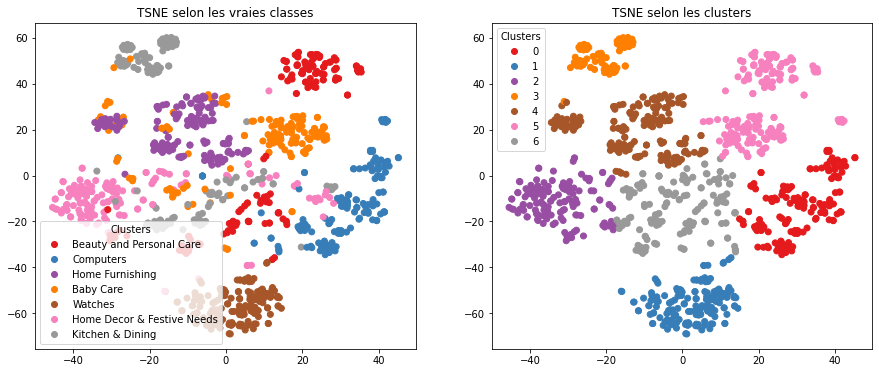

ARI :  0.5603


In [136]:
TSNE_visu_fct(X_tsne_tfidf, y_cat_num, labels_tfidf, ARI_tfidf)

In [138]:
d_tsne = pd.DataFrame(data = X_tsne_tfidf,columns = ["c1","c2"])
wc_idx = d_tsne[((d_tsne["c1"]>-20)&(d_tsne["c1"]<-5))|((d_tsne["c2"]>16)&(d_tsne["c2"]<40))].index
data_wc = data_.iloc[wc_idx]
data_wc["category"].value_counts()
# data_wc.loc[wc_idx[59],"sentence_bow"]

## Word2Vec

In [56]:
personal_sw_list_w2v = ["key","features", "flipkart.com", "great", "only", "replacement", "guarantee", "free", "shipping",
                    "cash", "delivery", "discounts","specifications",]
#                     "online", "india", "genuine", "products", "day","buy",
#                     "product","warranty","sale", "package","general","inch","size","made","dimension"]

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_w2v(desc_text, personal_sw_list = personal_sw_list_w2v) :
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw, personal_sw_list)
#     lem_w = lemma_fct(sw)    
    transf_desc_text = ' '.join(sw)
    return transf_desc_text

def embedding_mtx(word_index, model_vectors, w2v_size):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0
    w2v_words = model_vectors.index_to_key
    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
    word_rate = np.round(j/i,4)
    return embedding_matrix, word_rate

def run_word2vec_model(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, n_comp = 2, perplexity = 30):
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                       window=w2v_window,
                                       vector_size=w2v_size,
                                       seed=42,
                                       workers=1)
    #                                  workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=maxlen, padding='post') 

    num_words = len(tokenizer.word_index) + 1

    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    embedding_matrix, word_rate = embedding_mtx(word_index, model_vectors, w2v_size)
    
    input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size, output_dim=w2v_size, weights = [embedding_matrix],input_length=maxlen)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)

    embeddings = embed_model.predict(x_sentences, verbose = 0)

    ARI, X_tsne, labels = ARI_fct(embeddings, n_comp = n_comp, perplexity = 30)
    
    return ARI, X_tsne, labels

In [115]:
#pré-traitement pour le word2vec
data_['sentence_w2v'] = data_['description'].apply(lambda x : transform_w2v(x, personal_sw_list = personal_sw_list_w2v))

In [116]:
w2v_size=500
w2v_window=3
w2v_min_count=1
w2v_epochs=100
maxlen = 36 # adapt to length of sentences
sentences = data_['sentence_w2v'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [59]:
# Cross validation

# ari_scores = []
# params = {"w2v_size":[],"maxlen":[],"w2v_window":[],"w2v_epochs":[]}
# for w2v_size in [300,500,700]:
#     for maxlen in [250,300,350]: # Augmenter
#         for w2v_window in [3]:
#             for w2v_epochs in [100,200,300]:
#                 print("w2v_size :", w2v_size, "maxlen :", maxlen, "w2v_window :", w2v_window, "w2v_epochs :", w2v_epochs)
#                 ari, X_tsne, labels = run_word2vec_model(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, n_comp = 2)
#                 print("ARI :", ari)
#                 ari_scores.append(ari)
#                 params["w2v_size"].append(w2v_size)
#                 params["maxlen"].append(maxlen)
#                 params["w2v_window"].append(w2v_window)
#                 params["w2v_epochs"].append(w2v_epochs)

In [60]:
# import cross validation result
import json
with open('w2v_cross_results_no_numbers_3.json') as d:
    results = json.load(d)
ari_scores = results["ari_scores"]
params = results
del params["ari_scores"]

In [253]:
# # find best parameters
# opt_idx = ari_scores.index(max(ari_scores))
# print("best_params :", "ARI :", max(ari_scores))
# print("w2v_size :", params["w2v_size"][opt_idx],
#       "maxlen :", params["maxlen"][opt_idx],
#       "w2v_window :", params["w2v_window"][opt_idx],
#       "w2v_epochs :", params["w2v_epochs"][opt_idx])

ARI :  0.4659 time :  8.0


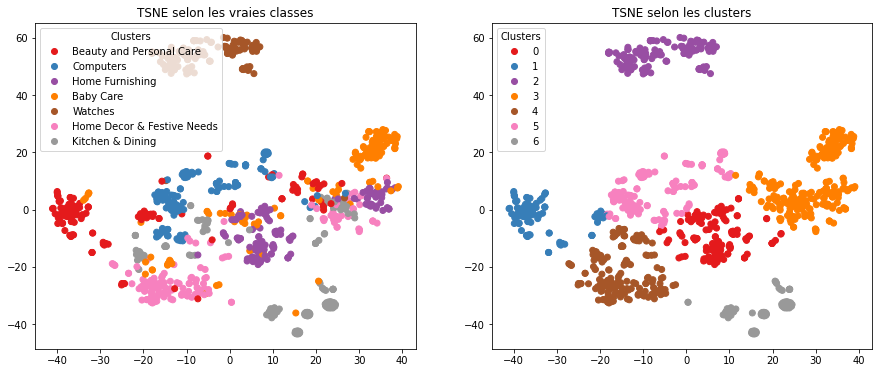

ARI :  0.4659


In [118]:
ARI_w2v, X_tsne_w2v, labels_w2v = run_word2vec_model(sentences,
                                         params["w2v_size"][opt_idx],
                                         params["w2v_window"][opt_idx],
                                         w2v_min_count,
                                         params["w2v_epochs"][opt_idx],
                                         params["maxlen"][opt_idx],
                                         n_comp = 2,
                                         perplexity = 30)
TSNE_visu_fct(X_tsne_w2v, y_cat_num, labels_w2v, ARI_w2v)

In [166]:
# d_tsne = pd.DataFrame(data = X_tsne_w2v,columns = ["c1","c2"])
# wc_idx = d_tsne[((d_tsne["c1"]>-20)&(d_tsne["c1"]<-5))|((d_tsne["c2"]>16)&(d_tsne["c2"]<40))].index
# data_wc = data_.iloc[wc_idx]
# data_wc["category"].value_counts()
# # data_wc.loc[wc_idx[59],"sentence_bow"]

In [167]:
data_wc.loc[wc_idx[27],"sentence_bow"]

'vitamin embroidered baby girl denim short detail ideal baby girl occasion casual pattern embroidered short detail type denim short fabric cotton pocket mitered patch pocket thigh number content sale pack fabric care gentle machine wash lukewarm water bleach additional detail style code raw rani box short'

In [165]:
data_wc.loc[wc_idx[27],"category"]

'Baby Care'

In [159]:
data_wc.loc[wc_idx[96],"sentence_bow"]

'ethnic story royal durban showpiece ethnic story royal durban showpiece best price'

In [112]:
data_wc.loc[wc_idx[121],"sentence_bow"]

'wild stone red juice combo set'

In [188]:
# # saving results
# import json
# results = params
# results["ari_scores"]=ari_scores
# with open("w2v_cross_results_no_numbers_3.json","w") as f:
#     json.dump(results,f)

## Bidirectional Encoder Representations from Transformers (BERT)

In [63]:
# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_bert(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)
    lem_w = lemma_fct(sw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [64]:
data_['sentence_dl'] = data_['description'].apply(lambda x : transform_bert(x))

In [65]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


## BERT hub Tensorflow

In [68]:
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
# model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_layer = hub.KerasLayer(model_url, trainable=True)
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer
sentences = data_['sentence_dl'].to_list()

In [119]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model,
                                                         model_type,
                                                         sentences, 
                                                         max_length,
                                                         batch_size,
                                                         mode='TFhub')

In [120]:
ARI_bert, X_tsne_bert, labels_bert = ARI_fct(features_bert, n_comp = 2)

ARI :  0.3394 time :  8.0


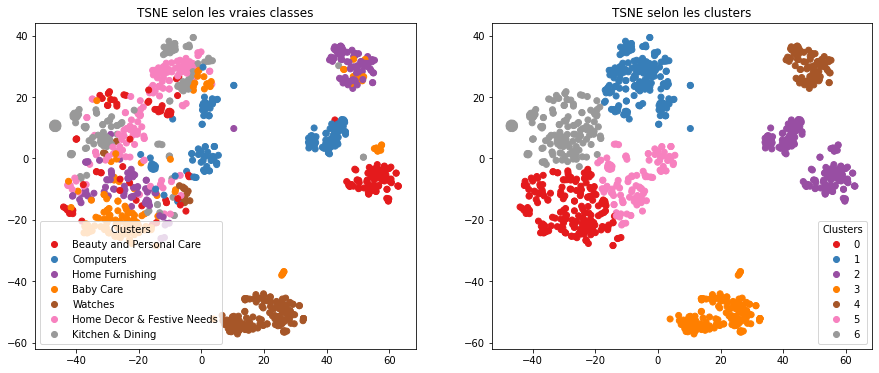

ARI :  0.3394


In [121]:
TSNE_visu_fct(X_tsne_bert, y_cat_num, labels_bert, ARI_bert)

In [ ]:
d_tsne = pd.DataFrame(data = X_tsne_bert,columns = ["c1","c2"])
wc_idx = d_tsne[((d_tsne["c1"]>-20)&(d_tsne["c1"]<-5))|((d_tsne["c2"]>16)&(d_tsne["c2"]<40))].index
data_wc = data_.iloc[wc_idx]
data_wc["category"].value_counts()
# data_wc.loc[wc_idx[59],"sentence_bow"]

## Universal Sentence Encoder (USE)

In [72]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
    time2 = np.round(time.time() - time1,0)
    return features

In [73]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [75]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
batch_size = 10
sentences = data_['sentence_dl'].to_list()

In [76]:
features_USE = feature_USE_fct(sentences, batch_size)

In [132]:
ARI_use, X_tsne_use, labels_use = ARI_fct(features_USE, n_comp = 2)

ARI :  0.4076 time :  8.0


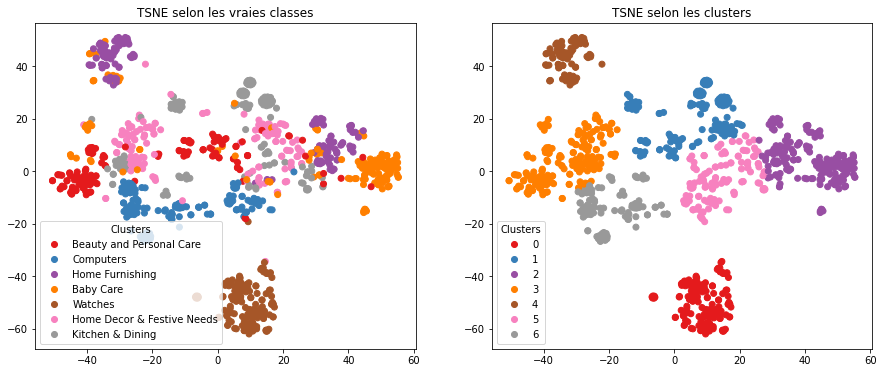

ARI :  0.4076


In [133]:
TSNE_visu_fct(X_tsne_use, y_cat_num, labels_use, ARI_use)

In [134]:
d_tsne = pd.DataFrame(data = X_tsne_use,columns = ["c1","c2"])
wc_idx = d_tsne[((d_tsne["c1"]>-20)&(d_tsne["c1"]<-5))|((d_tsne["c2"]>16)&(d_tsne["c2"]<40))].index
data_wc = data_.iloc[wc_idx]
data_wc["category"].value_counts()
# data_wc.loc[wc_idx[59],"sentence_bow"]

Kitchen & Dining              92
Home Decor & Festive Needs    44
Home Furnishing               28
Computers                     28
Baby Care                     21
Beauty and Personal Care      20
Watches                        6
Name: category, dtype: int64

# <p style = "text-align:center"> Classification d'image </p>

# SIFT

In [79]:
%matplotlib inline
path = "Flipkart\\Images\\"
list_photos = data_0["image"]
print(len(list_photos))

1050


In [256]:
data_img = data_0[["image","category"]].rename(columns = {"image":"image_path", "category":"label_name"})
le = preprocessing.LabelEncoder()
data_img["label"] = le.fit_transform(data_img["label_name"])

In [257]:
def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data_img)) if data_img["label_name"][i]==name]
    return list_image_name

list_kitchen=[list_photos[i] for i in range(len(data_img)) if data_img["label_name"][i]=='Kitchen & Dining']
list_baby=[list_photos[i] for i in range(len(data_img)) if data_img["label_name"][i]=='Baby Care']
list_computer=[list_photos[i] for i in range(len(data_img)) if data_img["label_name"][i]=='Computers']
list_home=[list_photos[i] for i in range(len(data_img)) if data_img["label_name"][i]=='Home Furnishing']
list_deco=[list_photos[i] for i in range(len(data_img)) if data_img["label_name"][i]=='Home Decor & Festive Needs']
list_beauty=[list_photos[i] for i in range(len(data_img)) if data_img["label_name"][i]=='Beauty and Personal Care']
list_watch=[list_photos[i] for i in range(len(data_img)) if data_img["label_name"][i]=='Watches']

list_labels = list(data_img["label_name"].unique())

# Affichage d'exemple :
# for name in list_labels :
#     print(name)
#     # print("-------")
#     for i in range(3):
#         plt.subplot(130 + 1 + i)
#         filename = path + list_fct(name)[i+10]
#         image = imread(filename)
#         plt.imshow(image)
#     plt.show()

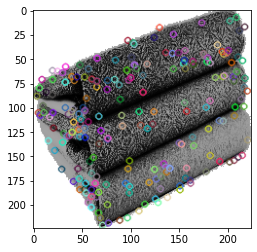

Descripteurs :  (231, 128)

[[  3.   2.   0. ...   0.   0.   0.]
 [ 12.  38.  23. ...   0.   0.   1.]
 [  4.  12. 178. ...   0.   0.  15.]
 ...
 [ 15.  10.   3. ...   0.   0.   7.]
 [ 50.  13.   0. ...   0.   0.   0.]
 [  1.   5.  11. ...   0.   0.  41.]]


In [258]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image_rsz = cv2.resize(image, (224,224))
image = cv2.equalizeHist(image_rsz)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [259]:
# identification of key points and associated descriptors
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path + list_photos[image_num],0) # convert in gray
    image_rsz = cv2.resize(image, (224,224))
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image_rsz)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (311986, 128)
temps de traitement SIFT descriptor :            35.88 secondes


C:\Users\Nabil\AppData\Local\Temp\ipykernel_26928\3309382533.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


In [87]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  559
Création de 559 clusters de descripteurs ...
temps de traitement kmeans :             8.80 secondes


In [88]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             5.69 secondes


In [89]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 559)
Dimensions dataset après réduction PCA :  (1050, 461)


ARI :  0.0439 time :  9.0


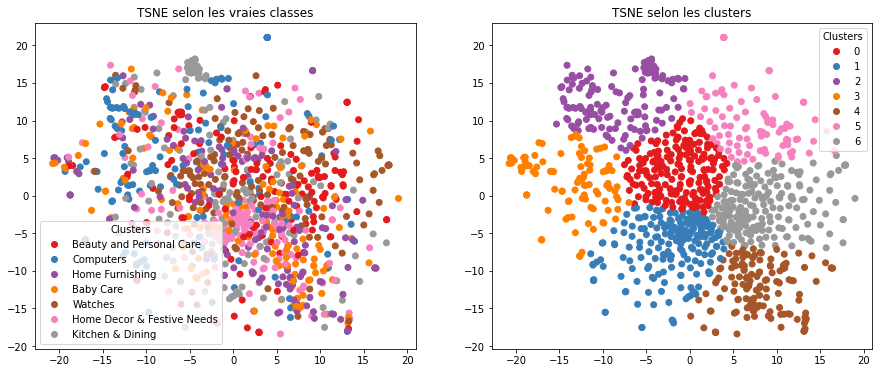

ARI :  0.0439


In [126]:
ARI_sift, X_tsne_sift, labels_sift = ARI_fct(feat_pca, n_comp = 2)

TSNE_visu_fct(X_tsne_sift, y_cat_num, labels_sift, ARI_sift)

In [128]:
# d_tsne = pd.DataFrame(data = X_tsne_sift,columns = ["c1","c2"])
# wc_idx = d_tsne[((d_tsne["c1"]>-20)&(d_tsne["c1"]<-5))|((d_tsne["c2"]>16)&(d_tsne["c2"]<40))].index
# data_wc = data_.iloc[wc_idx]
# data_wc["category"].value_counts()
# # data_wc.loc[wc_idx[59],"sentence_bow"]

# VGG16

## VGG16 Transfert Learning

In [ ]:
#RESNET, EFFICIENTNET

In [91]:
def ARI_fct(features, n_comp = 2, perplexity = 30) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=n_comp,perplexity=perplexity,n_iter=2000, init='random',learning_rate=200)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

In [92]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
new_model = Sequential()
new_model.add(model)
new_model.add(Flatten()) 
new_model.compile()

emb_vgg = np.zeros(shape = (1,25088))

for image_name in data_0["image"].values :
    img = load_img("Flipkart\\Images\\" + image_name, target_size=(224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
    y = new_model.predict(img)
    emb_vgg = np.concatenate([emb_vgg, y],axis=0) 


emb_vgg.shape

1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 255ms/step


C:\Users\Nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:3011: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 440ms/step


1/1 [==============================] - 0s 252ms/step


(1051, 25088)

ARI :  0.3169 time :  10.0


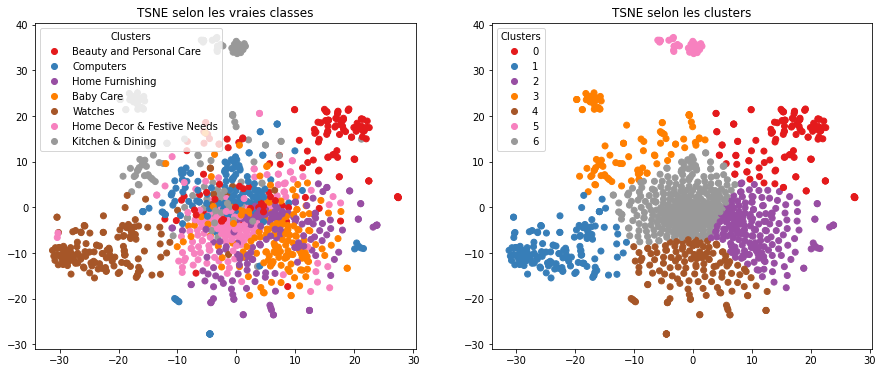

ARI :  0.3169


In [130]:
ARI_vgg, X_tsne_vgg, labels_vgg = ARI_fct(emb_vgg[1:], perplexity = 30)

TSNE_visu_fct(X_tsne_vgg, y_cat_num, labels_vgg, ARI_vgg)

In [131]:
d_tsne = pd.DataFrame(data = X_tsne_vgg,columns = ["c1","c2"])
wc_idx = d_tsne[((d_tsne["c1"]>-5)&(d_tsne["c1"]<5))|((d_tsne["c2"]>-5)&(d_tsne["c2"]<5))].index
data_wc = data_.iloc[wc_idx]
data_wc["category"].value_counts()
# data_wc.loc[wc_idx[59],"sentence_bow"]

Computers                     120
Home Furnishing               114
Home Decor & Festive Needs    104
Kitchen & Dining               76
Baby Care                      71
Beauty and Personal Care       51
Watches                        29
Name: category, dtype: int64

In [202]:
# m_reshaped = m[1:].reshape((1050,25088))
# m_reshaped.tofile('vgg16_matrix_2.csv',sep=',')

# Resnet

In [244]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = ResNet50(weights="imagenet", include_top=False, input_shape=None) #RESNET50
new_model = Sequential()
new_model.add(model)
new_model.add(Flatten()) 
new_model.compile()

emb_res = np.zeros(shape = (1,100352))

for image_name in data_0["image"].values :
    img = load_img("Flipkart\\Images\\" + image_name, target_size=(224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
    y = new_model.predict(img)
    emb_res = np.concatenate([emb_res, y],axis=0) 


emb_res.shape

1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 221ms/step


C:\Users\Nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:3011: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 231ms/step


(1051, 100352)

ARI :  0.4062 time :  11.0


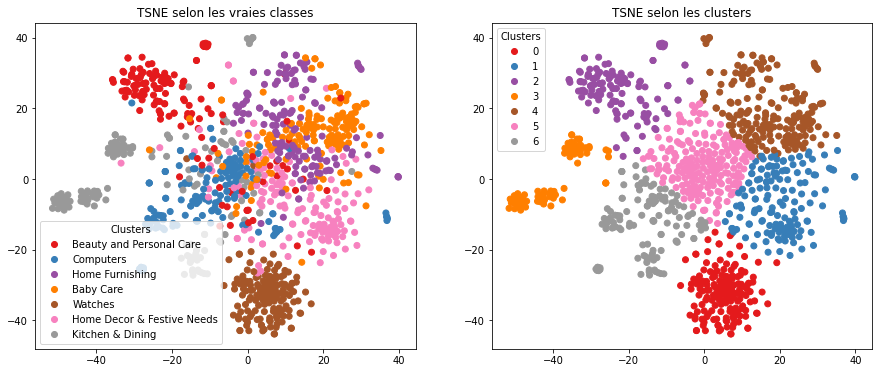

ARI :  0.4062


In [95]:
ARI_res, X_tsne_res, labels_res = ARI_fct(emb_res[1:], perplexity = 30)

TSNE_visu_fct(X_tsne_res, y_cat_num, labels_res, ARI_res)

In [ ]:
d_tsne = pd.DataFrame(data = X_tsne_res,columns = ["c1","c2"])
wc_idx = d_tsne[((d_tsne["c1"]>-20)&(d_tsne["c1"]<-5))|((d_tsne["c2"]>16)&(d_tsne["c2"]<40))].index
data_wc = data_.iloc[wc_idx]
data_wc["category"].value_counts()
# data_wc.loc[wc_idx[59],"sentence_bow"]

In [174]:
# import matplotlib.pyplot as plt
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# def getImage(path, zoom=1):
#     return OffsetImage(plt.imread(path), zoom=zoom)

# paths = ["Flipkart\\Images\\" + img_name for img_name in data_0["image"].values]
    
# x = X_tsne[:,0]
# y = X_tsne[:,1]

# fig, ax = plt.subplots(figsize = (15,15))
# ax.scatter(x, y, marker = paths) 

# # for x0, y0, path in zip(x, y, paths):
# #     ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
# #     ax.add_artist(ab)

# Classification - Approche supervisée

In [184]:
imgs = np.zeros(shape = (1,224,224,3))

for image_name in data_0["image"].values :
    img = load_img("Flipkart\\Images\\" + image_name, target_size=(224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input_resnet(img)  # Prétraiter l'image comme le veut VGG-16
    imgs = np.concatenate([imgs, img],axis=0) 

imgs.shape

C:\Users\Nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:3011: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1051, 224, 224, 3)

In [185]:
X = imgs[1:,:,:,:]
y = to_categorical(y_cat_num)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [186]:
X_train.shape

(703, 224, 224, 3)

In [187]:
X_test.shape

(347, 224, 224, 3)

In [188]:
len(y_train)

703

In [240]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)) #RESNET50 

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
l0 = Flatten()(x)
l1 = Dense(20, activation="relu")(l0)
l2 = Dense(10, activation="relu")(l1)
predictions = Dense(7, activation='softmax')(l2)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

# new_model = tensorflow.keras.models.Sequential([model,predictions])

for layer in new_model.layers[:-5]:
    layer.trainable = False

# Compiler le modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Entraîner sur les données d'entraînement (X_train, y_train)
#  epochs=3, batch_size=4, verbose=2 accuracy =0.7+
model_info = new_model.fit(X_train, y_train,epochs=5, batch_size=30)

C:\Users\Nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
24/24 [==============================] - 95s 4s/step - loss: 1.6825 - accuracy: 0.3514
Epoch 2/5
24/24 [==============================] - 94s 4s/step - loss: 0.9152 - accuracy: 0.6387
Epoch 3/5
24/24 [==============================] - 91s 4s/step - loss: 0.6104 - accuracy: 0.7952
Epoch 4/5
24/24 [==============================] - 92s 4s/step - loss: 0.4024 - accuracy: 0.8976
Epoch 5/5
24/24 [==============================] - 97s 4s/step - loss: 0.2746 - accuracy: 0.9459


In [241]:
y_pred = new_model.predict(X_test)

y_pred = y_pred.argmax(axis=1)

print("accuracy :", accuracy_score(y_pred,y_test.argmax(axis = 1)))

11/11 [==============================] - 40s 4s/step
accuracy : 0.7579250720461095


# Combining computer vision and nlp

In [ ]:
# combiner les xtsne

In [242]:
# ARI, X_tsne_tfidf, labels = ARI_fct(ctf_transform, n_comp=2)
num_labels=len(l_cat)
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=2000, 
                     init='random',
                     learning_rate=200,
                     random_state=42)
X_tsne_tfidf = tsne.fit_transform(ctf_transform)

In [245]:
# ARI, X_tsne_resnet, labels = ARI_fct(n[1:], perplexity = 30)
num_labels=len(l_cat)
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=2000, 
                     init='random',
                     learning_rate=200,
                     random_state=42)
X_tsne_resnet = tsne.fit_transform(emb_res[1:])

In [246]:
X_tsne_comb = np.concatenate([X_tsne_tfidf,X_tsne_resnet], axis= 1)
cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
cls.fit(X_tsne_comb)

KMeans(n_clusters=7, n_init=100, random_state=42)

0.5638


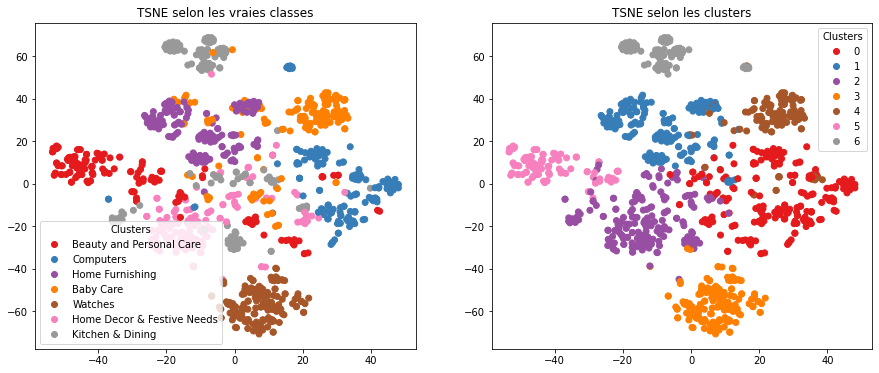

In [248]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
scatter = ax.scatter(X_tsne_comb[:,0],X_tsne_comb[:,1], c=y_cat_num, cmap='Set1')
ax.legend(handles=scatter.legend_elements()[0], labels=set(l_cat), loc="best", title="Clusters")
plt.title('TSNE selon les vraies classes')
ax = fig.add_subplot(122)
scatter = ax.scatter(X_tsne_comb[:,0],X_tsne_comb[:,1], c=cls.labels_, cmap='Set1')
ax.legend(handles=scatter.legend_elements()[0], labels=set(cls.labels_), loc="best", title="Clusters")
plt.title('TSNE selon les clusters')
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
print(ARI)